# Load Data

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [2]:
path = kagglehub.dataset_download("yashpaloswal/fraud-detection-credit-card")
print("Path to dataset files:", path)

for filename in os.listdir(path):
    if filename.endswith(".csv"):
        filepath = os.path.join(path, filename)
        try:
            df = pd.read_csv(filepath)
            print(f"Successfully loaded {filename} into a DataFrame.")
            break
        except pd.errors.ParserError:
            print(f"Error parsing {filename}. Skipping this file.")
        except Exception as e:
            print(f"An error occurred while loading {filename}: {e}")

df_backup = df.copy()

100%|██████████| 43.5M/43.5M [00:00<00:00, 119MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yashpaloswal/fraud-detection-credit-card/versions/1
Successfully loaded creditcard.csv into a DataFrame.


# Helper Functions

In [3]:
# Function for temporal train-test split

def temporal_split(df):
  split_time = df['Time'].quantile(0.8)
  train_df = df[df['Time'] <= split_time]
  test_df = df[df['Time'] > split_time]
  X_train = train_df.drop(columns=['class'])
  y_train = train_df['class']
  X_test = test_df.drop(columns=['class'])
  y_test = test_df['class']
  return X_train, y_train, X_test, y_test

In [4]:
# Splits dataset into folds

def split_into_folds(df, num_folds):
    fold_size = len(df) // num_folds
    folds = []
    for fold in range(num_folds):
        start = fold * fold_size
        if(fold == num_folds - 1):
            end = len(df)
        else:
            end = (fold + 1) * fold_size
        fold_df = df.iloc[start:end]
        folds.append(fold_df)
    return folds

In [5]:
# Function to perform Temporal K Fold and train/evaluate model

def run_temporal_kfold(df, model):

  print(f"\nModel: {model.__class__.__name__}")
  num_splits = 5
  tests = []
  predictions = []
  probabilities = []

  df = df.sort_values('Time').reset_index(drop=True)
  folds = split_into_folds(df, num_splits)

  for index, fold in enumerate(folds):

    X_train, y_train, X_test, y_test = temporal_split(fold)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    predictions.extend(y_pred)
    probabilities.extend(y_prob)
    tests.extend(y_test)

    # Confusion Matrix and Classification report
    print(f"\n\nClasses in Fold {index}: {y_test.value_counts().to_dict()}\n")
    print(f"Classification Report for Fold - {index}")
    print(classification_report(y_test, y_pred))


  # Showing final results across all folds
  final_auc = roc_auc_score(tests, probabilities)
  fpr, tpr, _ = roc_curve(tests, probabilities)
  plt.figure()
  plt.plot(fpr, tpr, label=f'Final ROC (AUC = {final_auc:.2f})', color='blue')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Final ROC Curve - {model.__class__.__name__} (All Folds)')
  plt.legend(loc='lower right')
  plt.grid()
  plt.show()

  cm = confusion_matrix(tests, predictions)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
  cm_display.plot(cmap='Blues')
  plt.title(f"Final Confusion Matrix for {model.__class__.__name__} (all folds)")
  plt.show()

  print(f"\n\nFinal Classification Report")
  print(classification_report(tests, predictions))

In [6]:
# Function to show lag features

def plot_acf_pacf_all(df, lags=40, exclude_cols=['Time', 'class']):
    features = [col for col in df.columns if col not in exclude_cols]

    for col in features:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        fig.suptitle(f'ACF and PACF for {col}', fontsize=16)

        plot_acf(df[col], lags=lags, ax=axes[0])
        plot_pacf(df[col], lags=lags, ax=axes[1], method='ywm')

        axes[0].set_title(f'{col} - ACF')
        axes[1].set_title(f'{col} - PACF')
        plt.tight_layout()
        plt.show()

In [7]:
def add_lag_features(df, lag_config, y_col='class', substitute_value=-999):

    df_copy = df.copy()

    #Create lag features
    for col, num_lags in lag_config.items():
        for lag in range(1, num_lags + 1):
            df_copy[f"{col}_lag{lag}"] = df_copy[col].shift(lag)

    #Identify all lag columns
    lag_cols = [f"{col}_lag{lag}" for col, n in lag_config.items() for lag in range(1, n + 1)]

    #Split into positive and negative classes
    positives = df_copy[df_copy[y_col] == 1].copy()
    negatives = df_copy[df_copy[y_col] == 0].copy()

    #Fill nulls in positive class
    positives[lag_cols] = positives[lag_cols].fillna(substitute_value)

    #Drop rows with any NaN in negative class
    negatives = negatives.dropna(subset=lag_cols)

    #Combine back
    df_final = pd.concat([positives, negatives]).sort_index()

    return df_final

# Preprocessing

In [8]:
print(df['class'].value_counts(normalize=True)*100)
print(f"Number of rows: {df.shape[0]}")

class
0    99.827251
1     0.172749
Name: proportion, dtype: float64
Number of rows: 284807


In [9]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
original_df = df.copy()

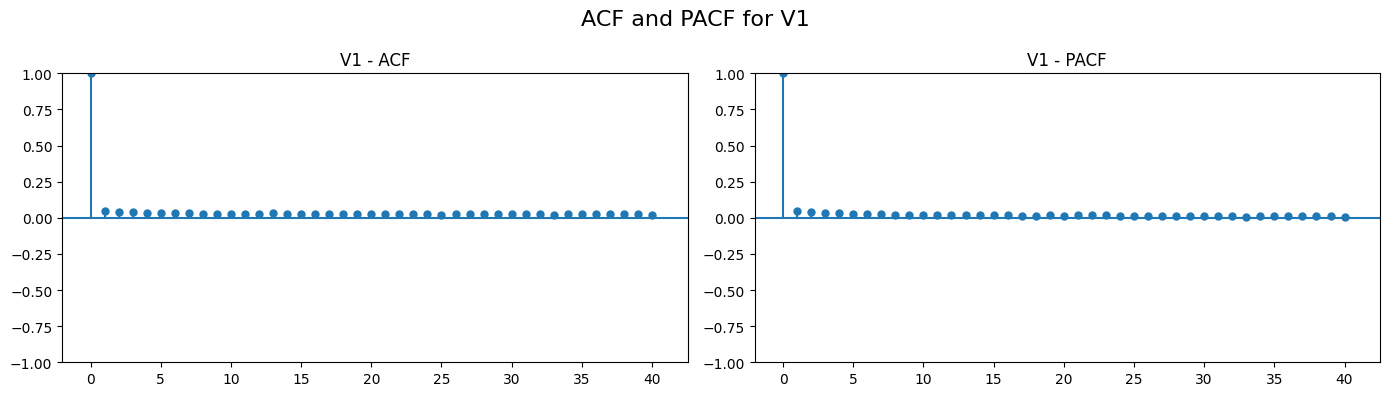

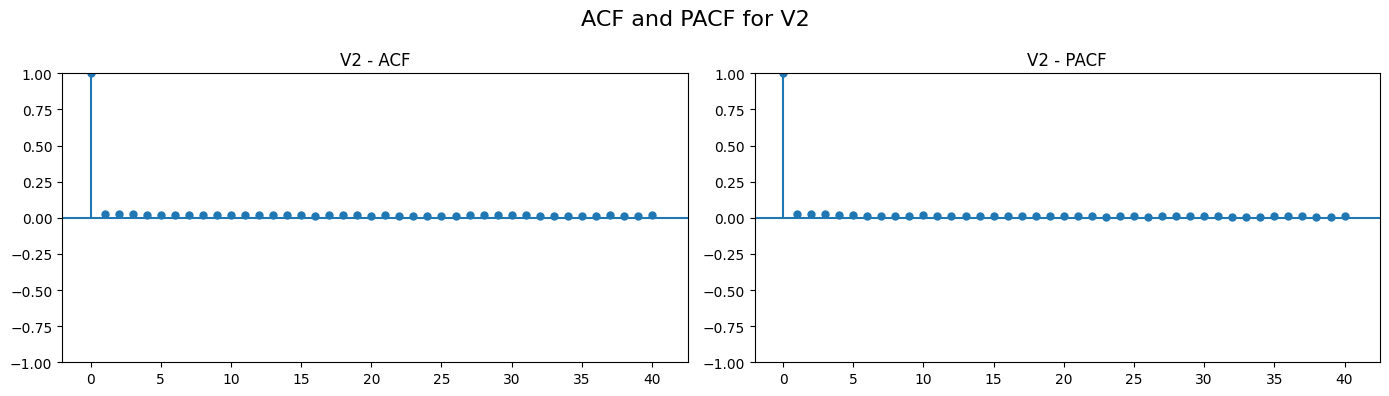

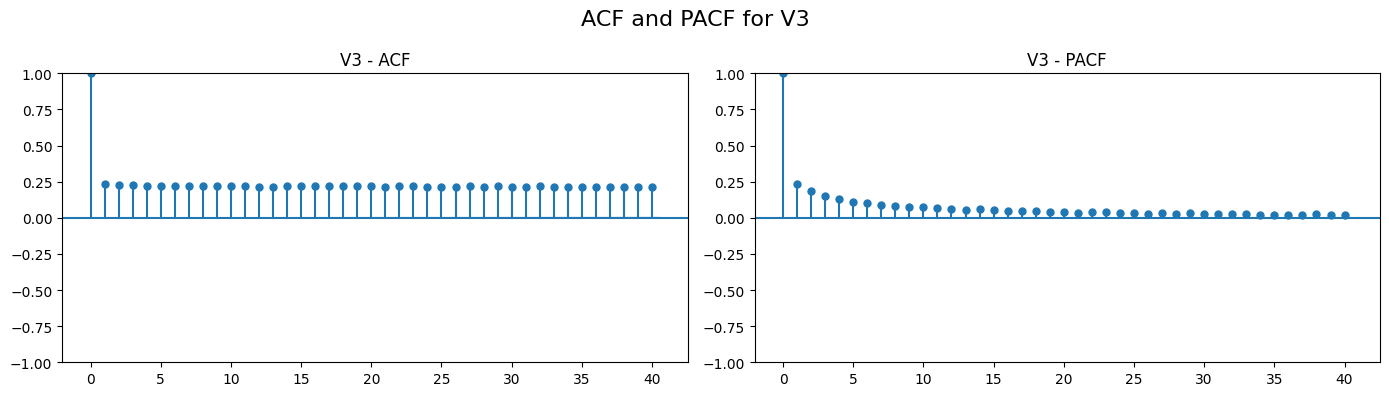

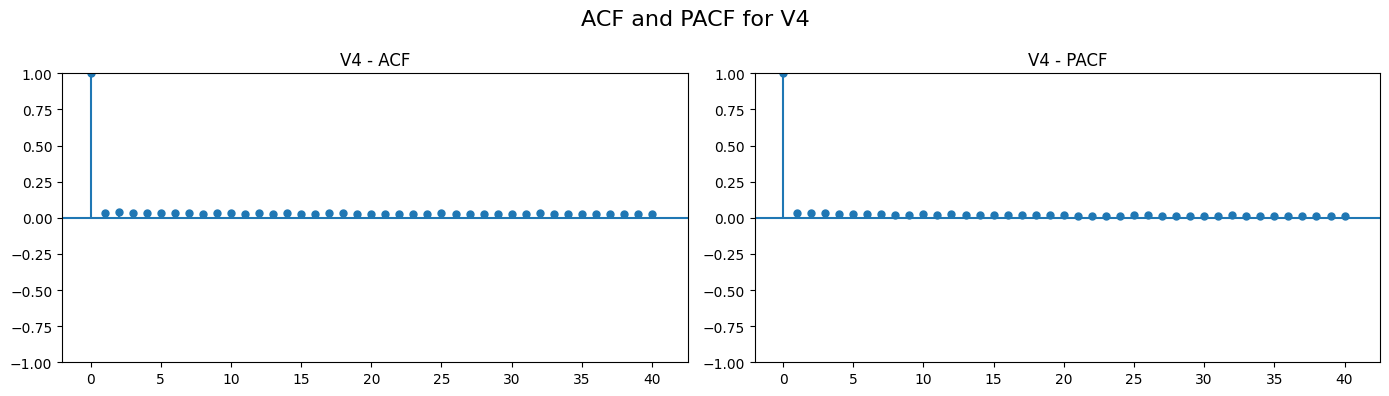

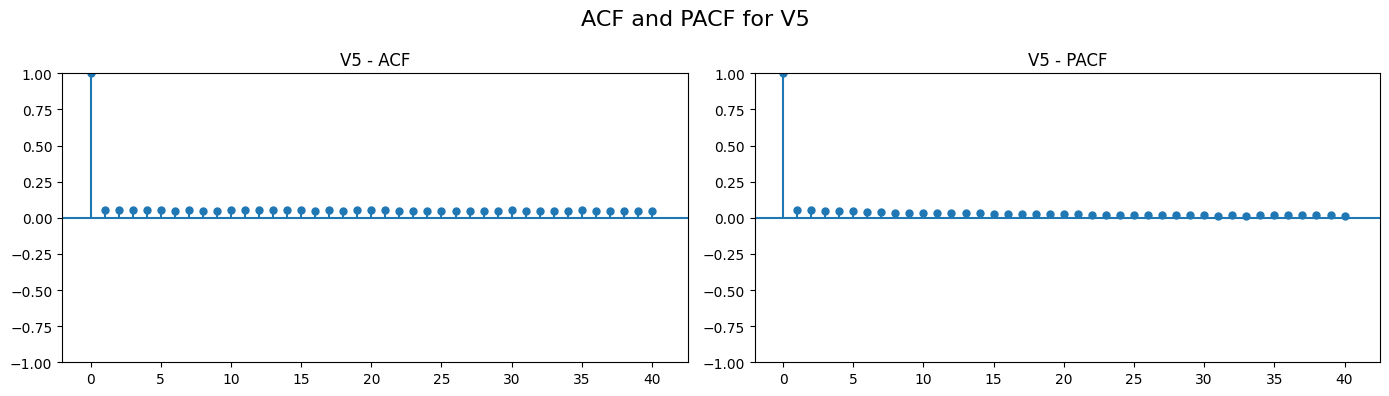

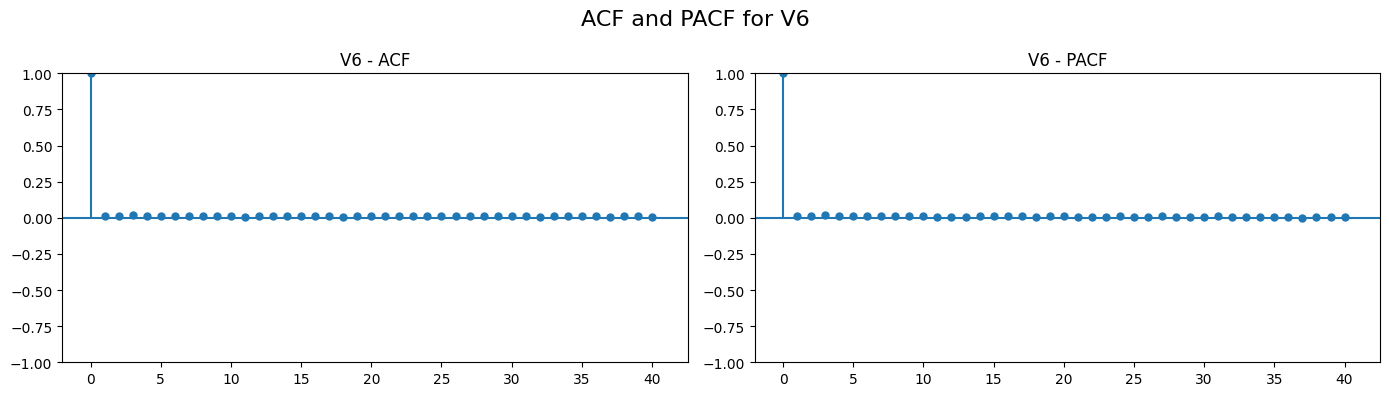

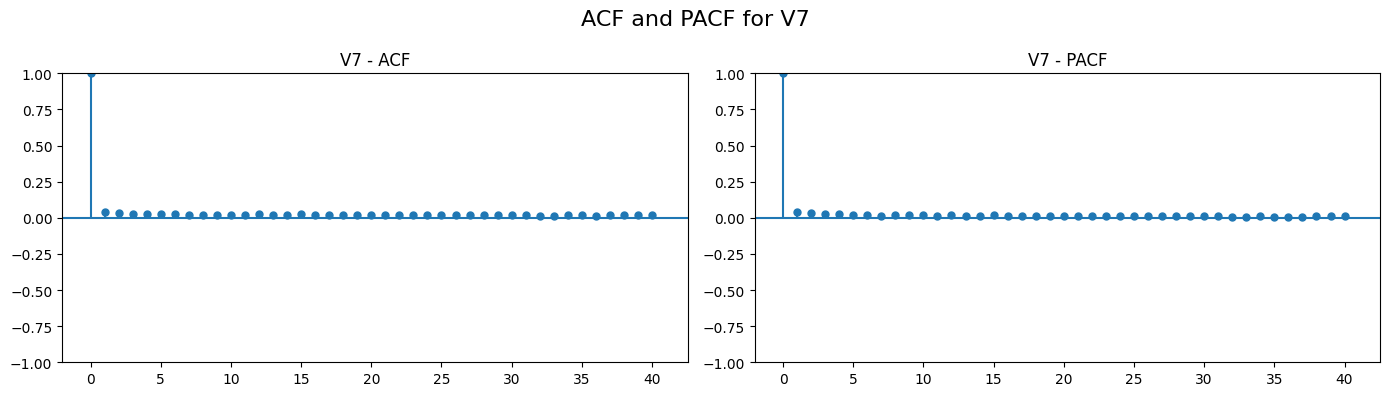

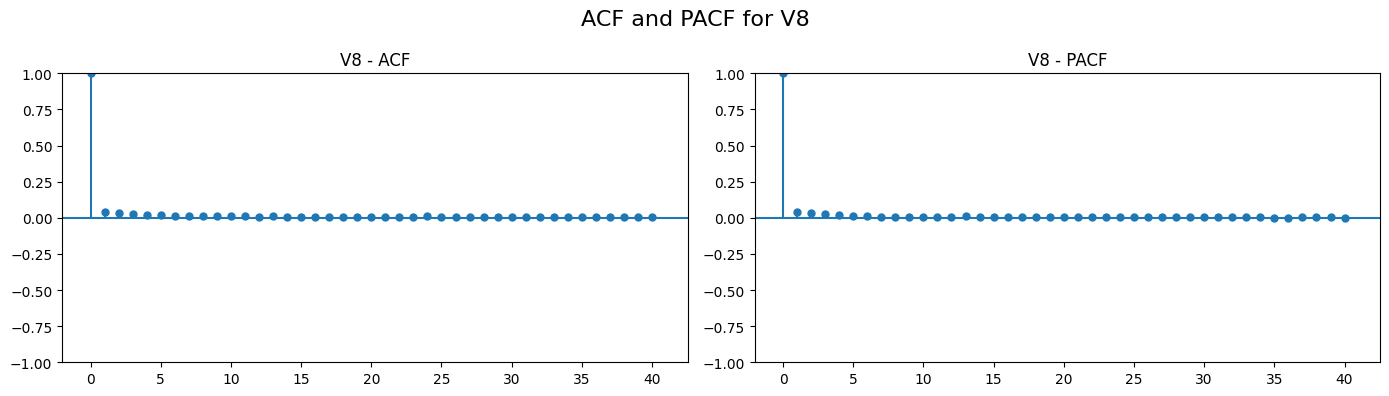

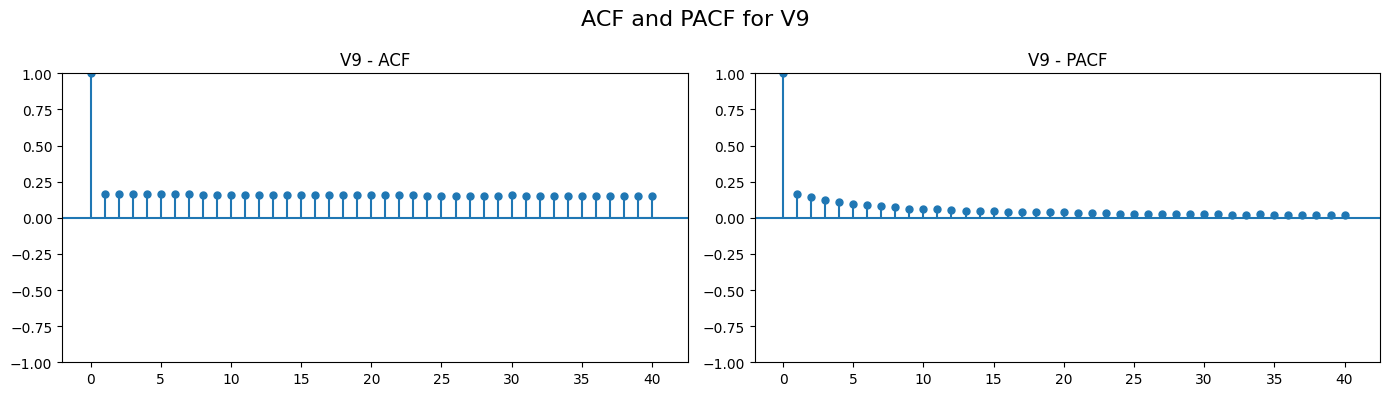

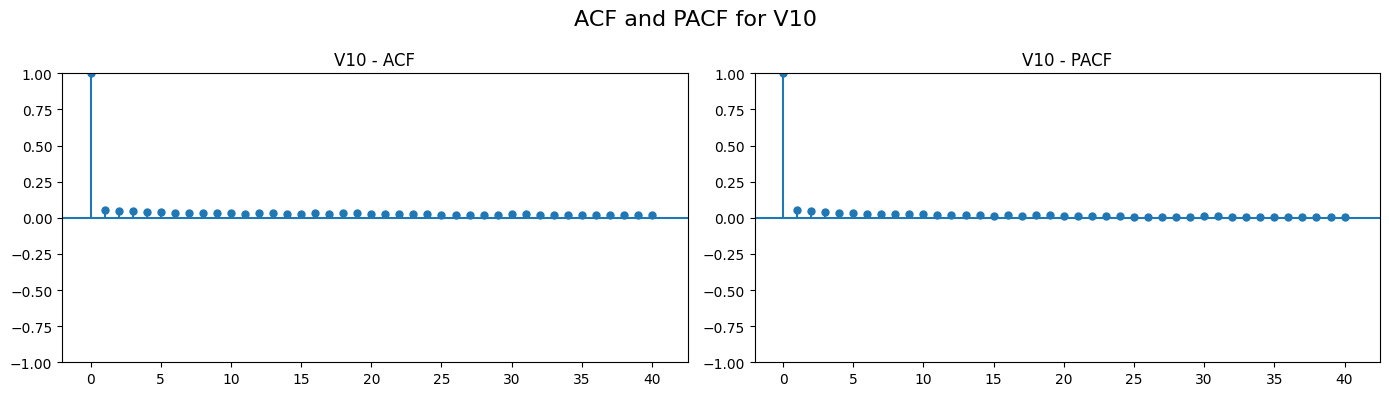

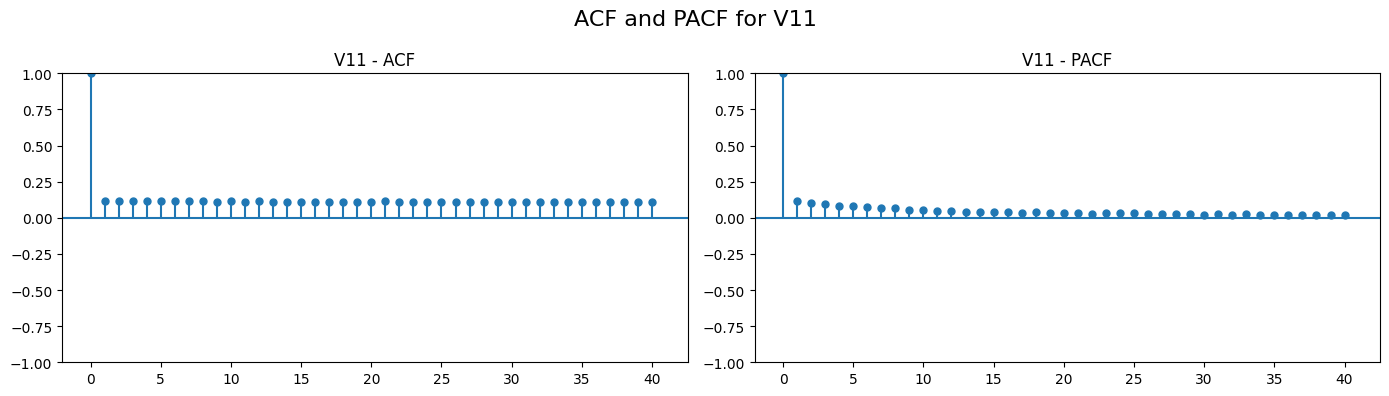

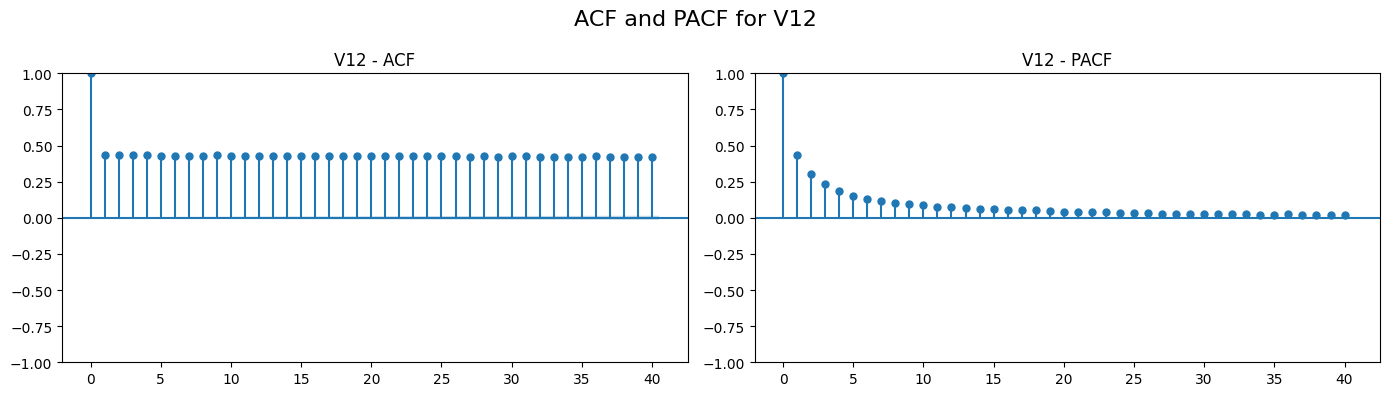

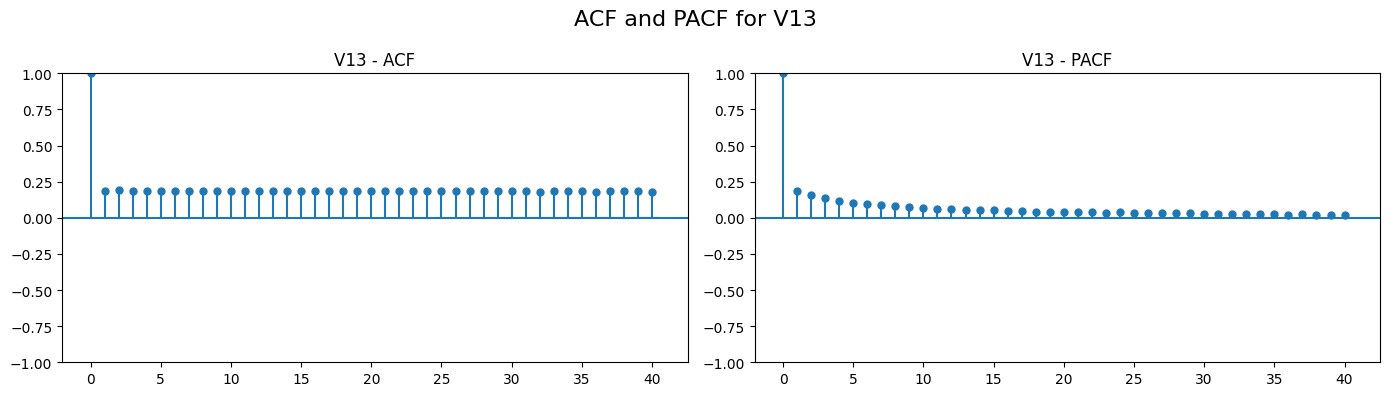

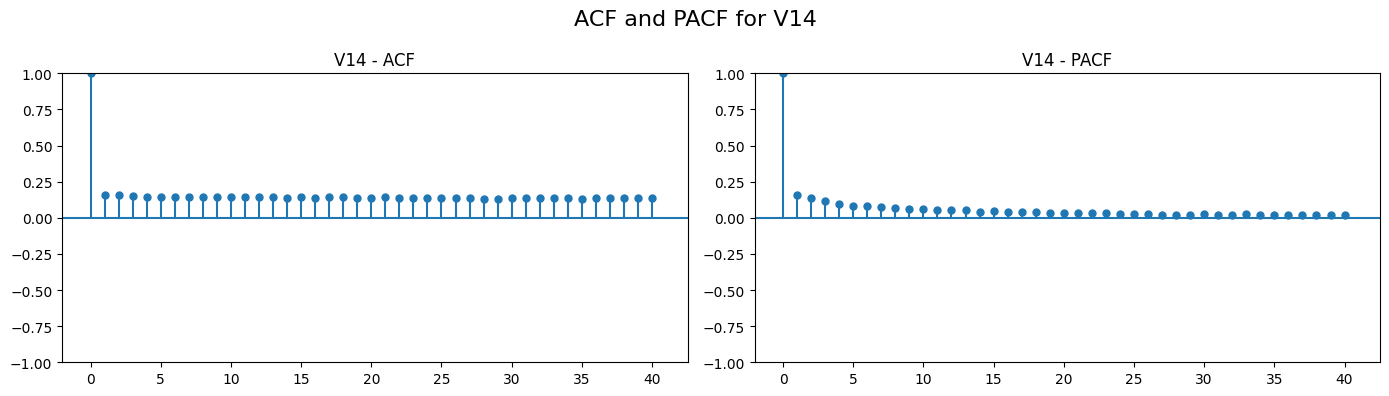

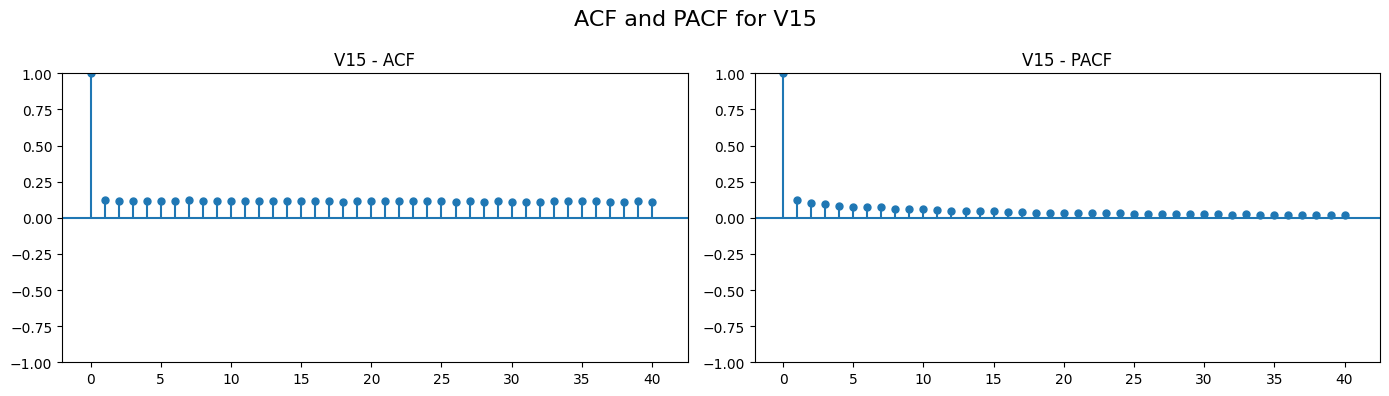

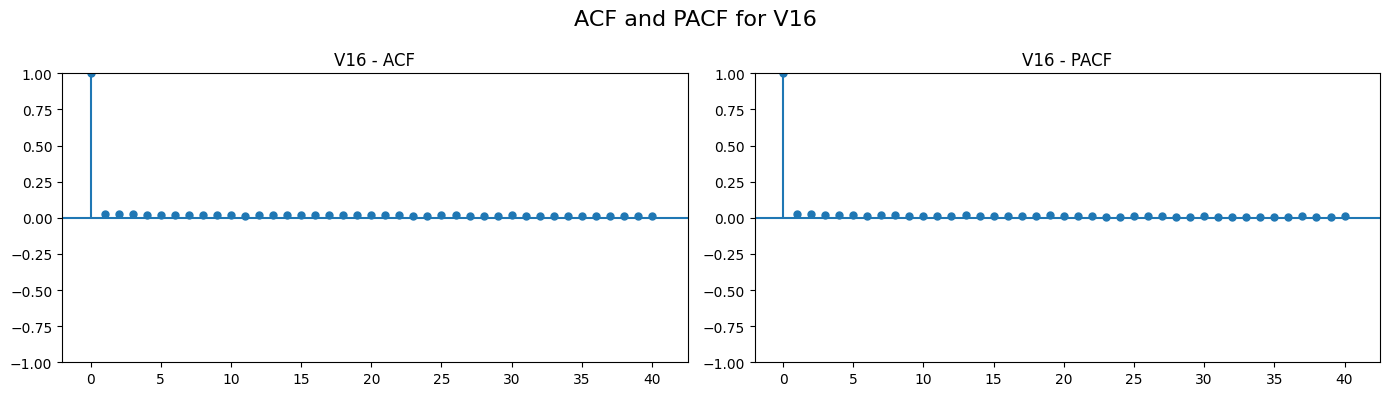

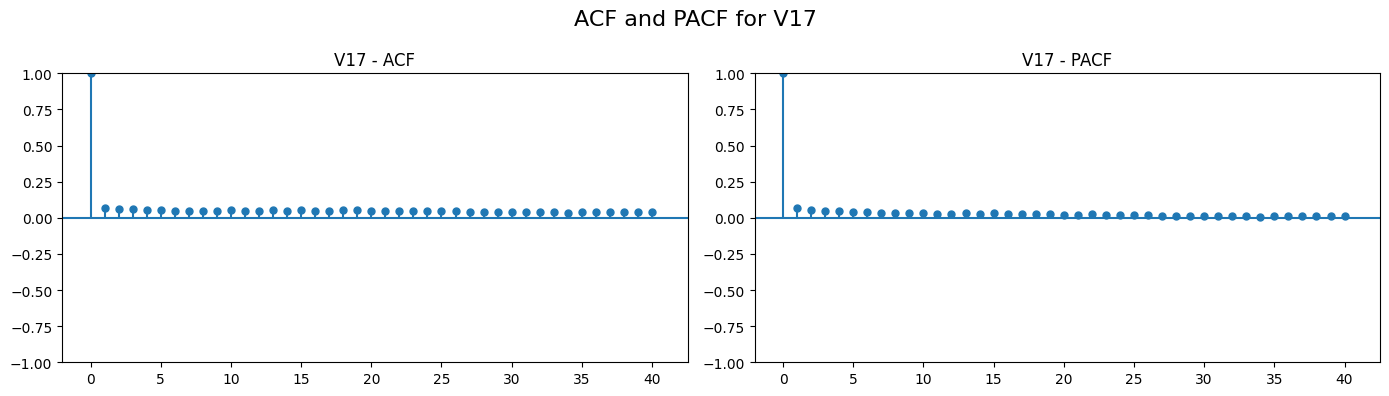

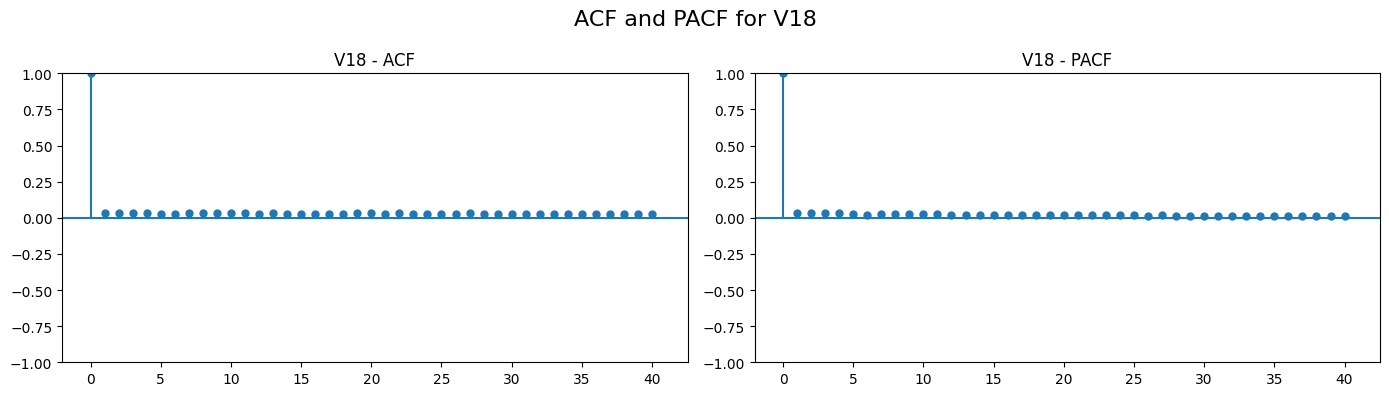

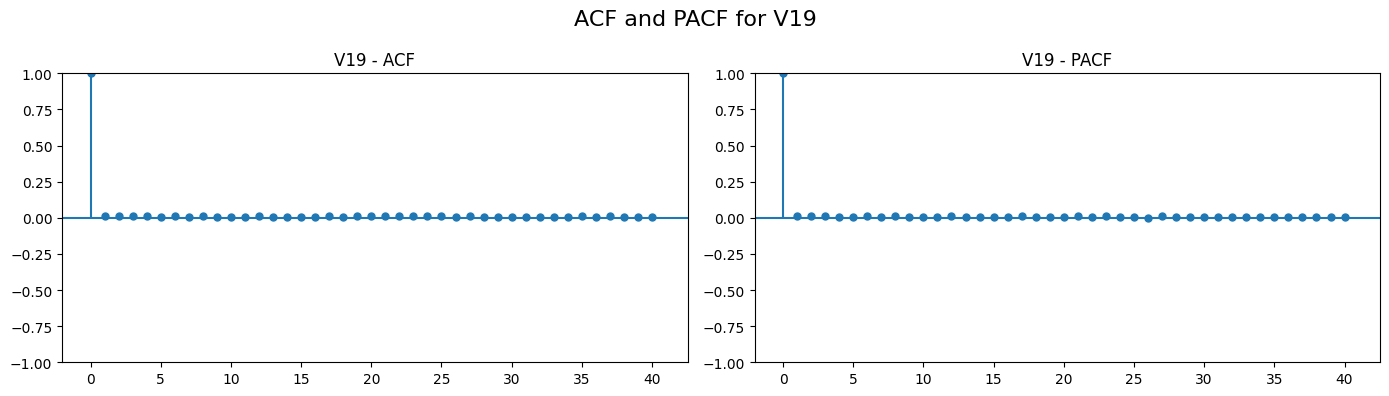

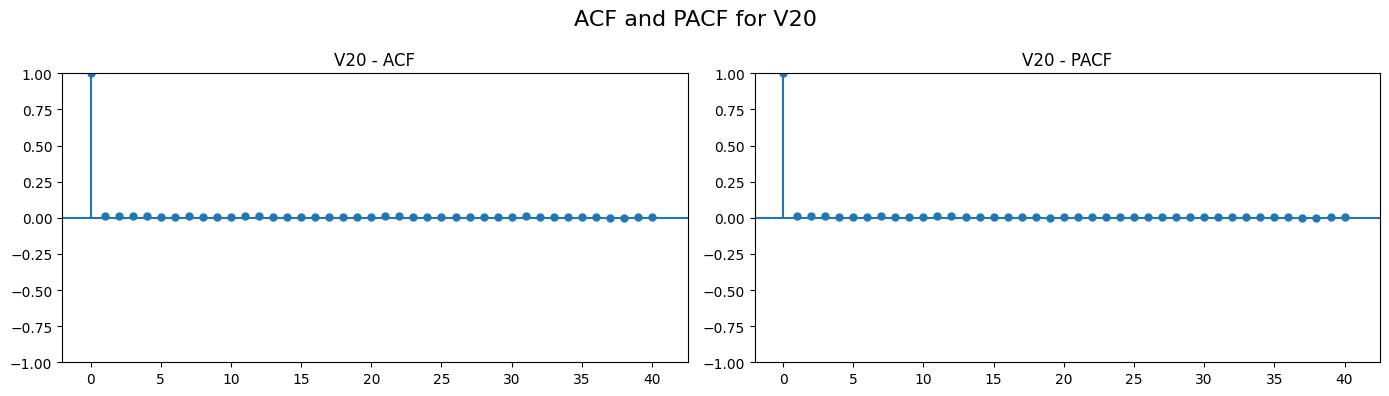

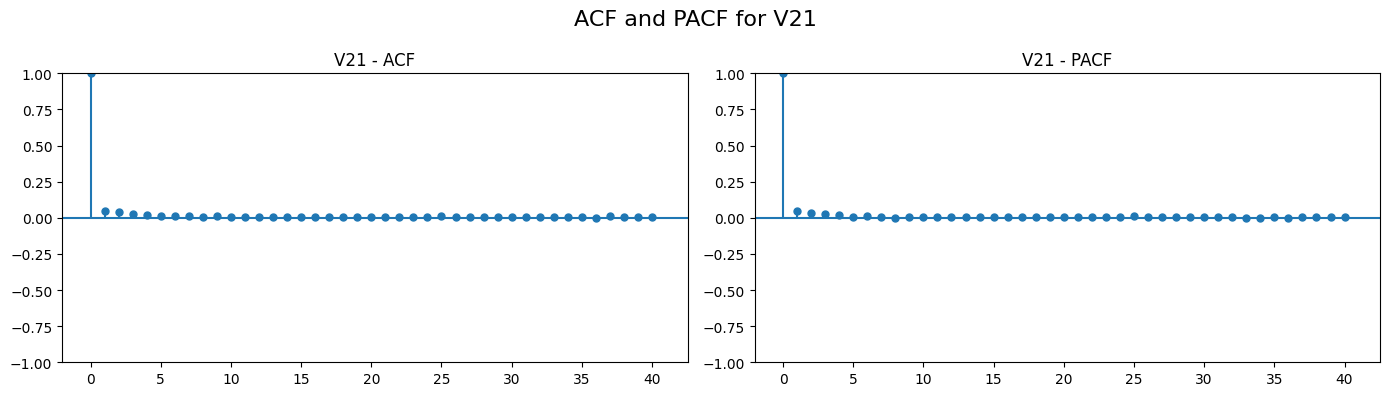

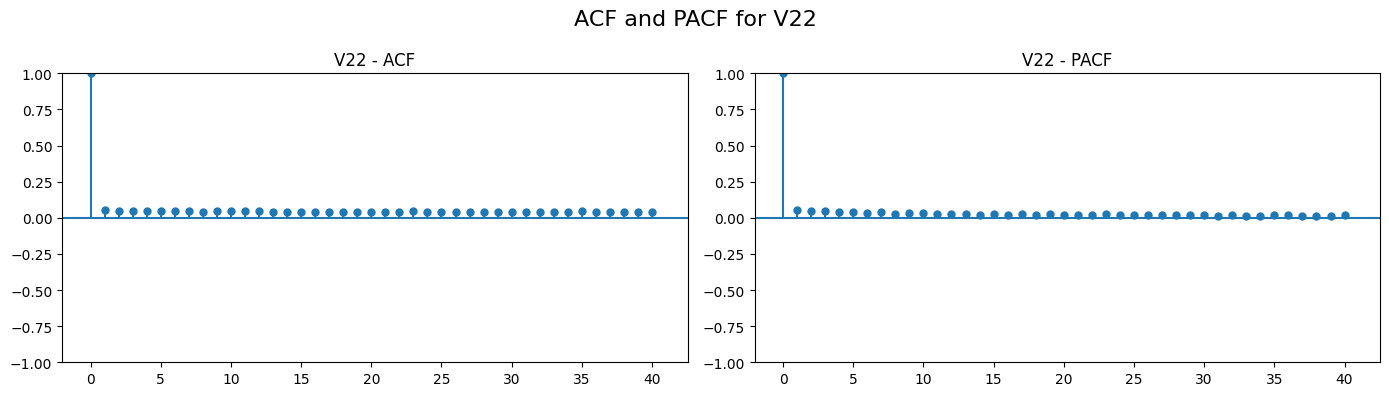

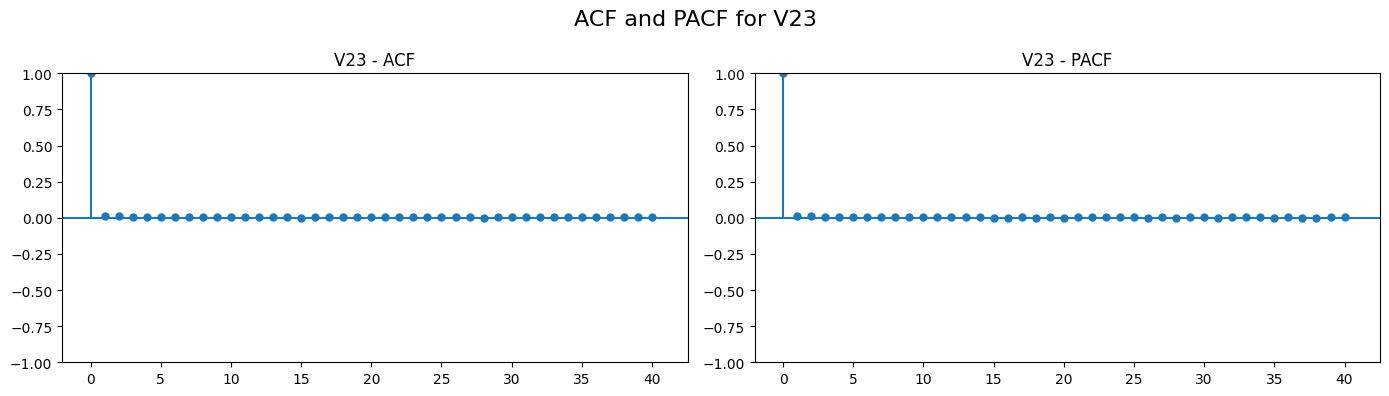

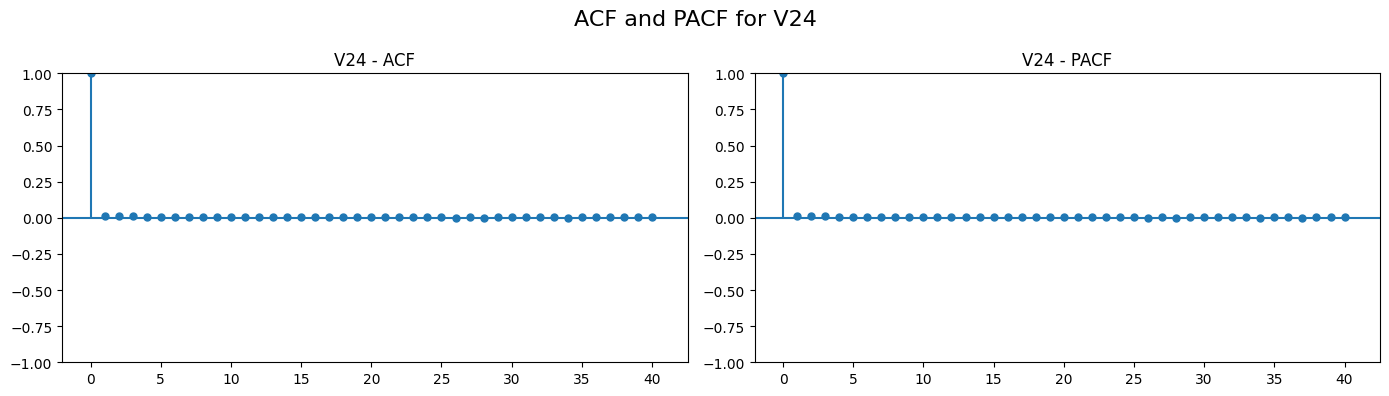

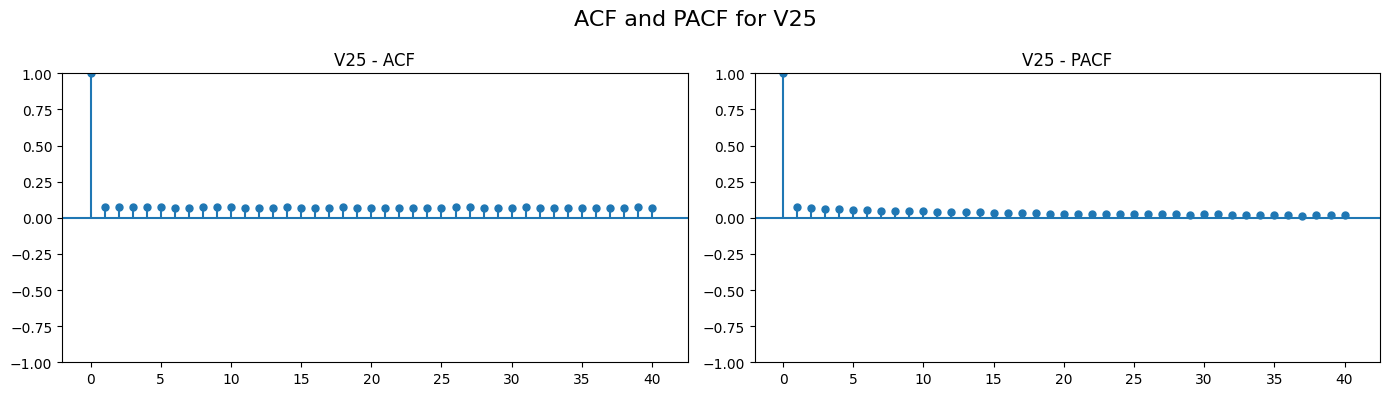

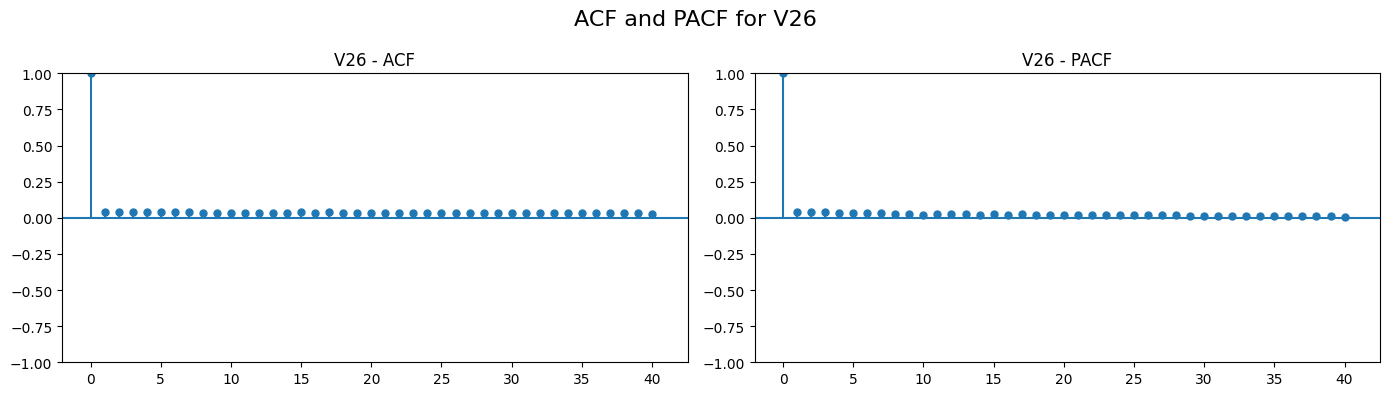

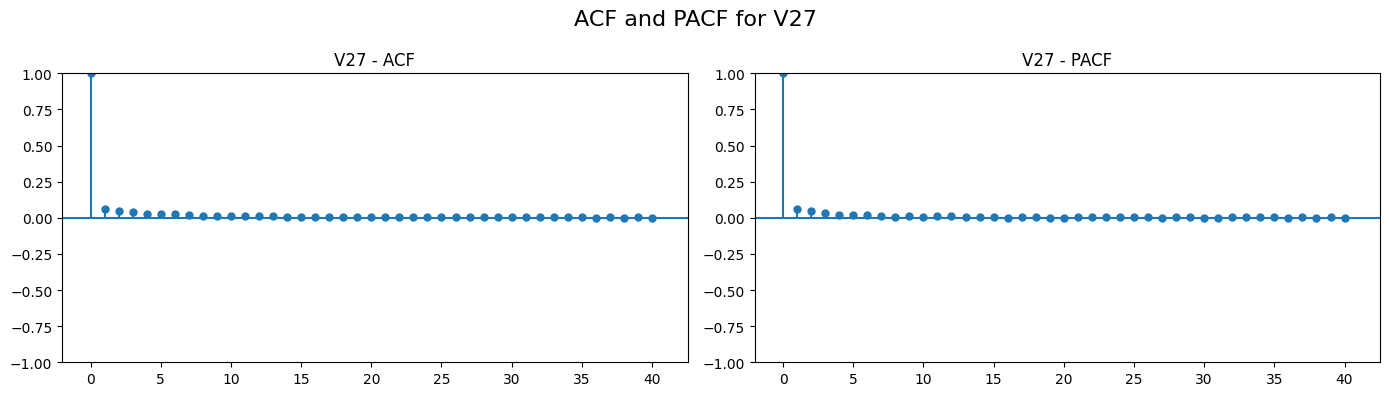

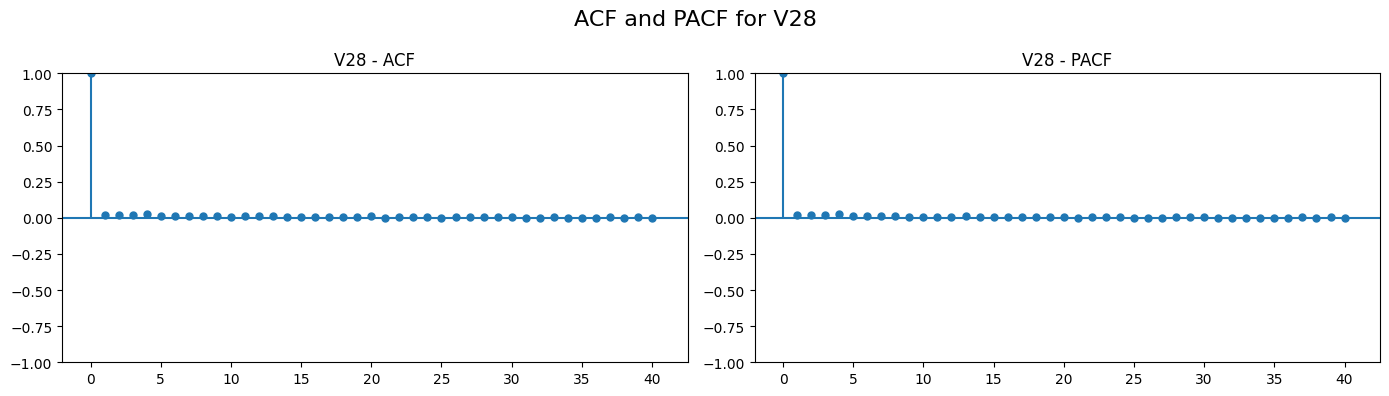

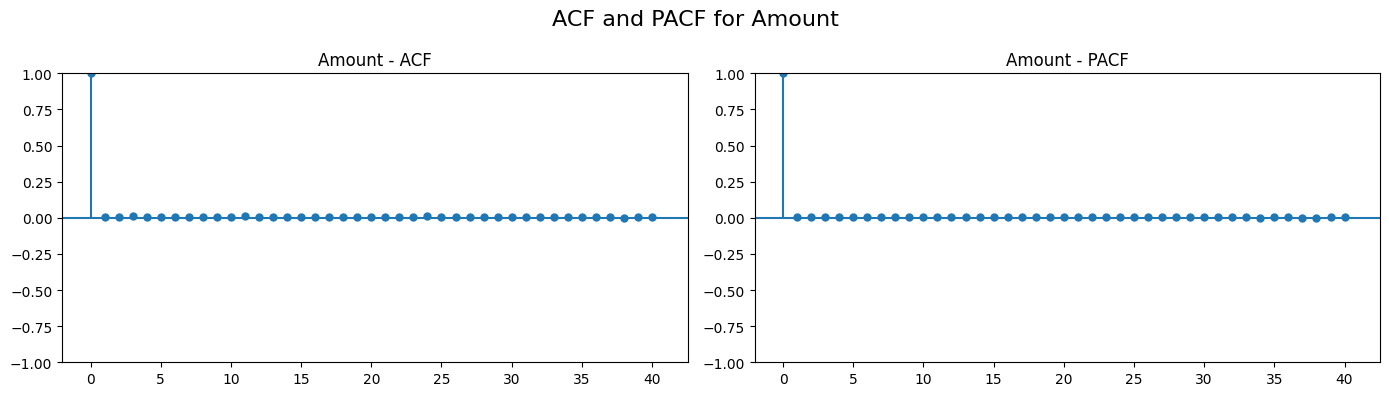

In [10]:
plot_acf_pacf_all(df)

In [11]:
#Add lag features

lag_config = {
    'V3': 2,
    'V9': 1,
    'V12': 3,
    'V13': 1,
    'V14': 1,
}
df =  add_lag_features(df, lag_config)

In [12]:
X = df.drop('class', axis=1)
y = df['class']

# XGBOOST

In [13]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Using ADASYN for XGBOOST
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
resampled_df = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)


Model: XGBClassifier


Classes in Fold 0: {1: 13905, 0: 8839}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       0.61      1.00      0.75      8839
           1       1.00      0.59      0.74     13905

    accuracy                           0.75     22744
   macro avg       0.80      0.79      0.75     22744
weighted avg       0.85      0.75      0.75     22744



Classes in Fold 1: {1: 12519, 0: 10226}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       0.93      1.00      0.97     10226
           1       1.00      0.94      0.97     12519

    accuracy                           0.97     22745
   macro avg       0.97      0.97      0.97     22745
weighted avg       0.97      0.97      0.97     22745



Classes in Fold 2: {1: 17611, 0: 5134}

Classification Report for Fold - 2
              precision    recall  f1-score   support

           0       0.96      1.00    

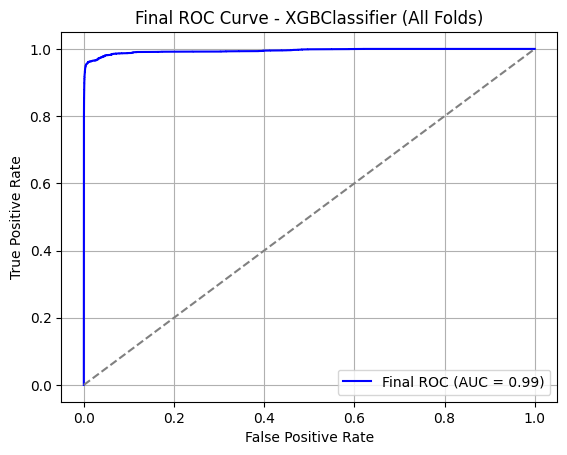

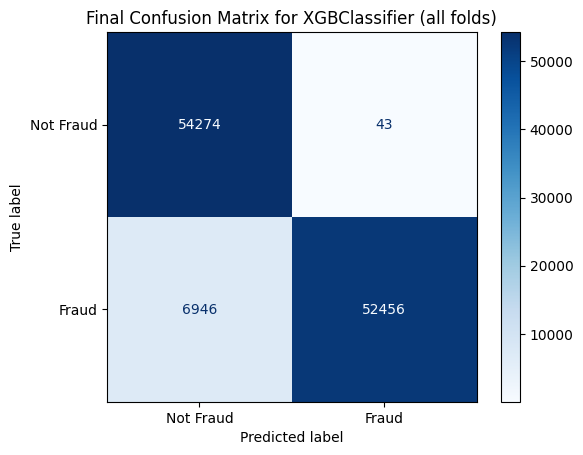



Final Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     54317
           1       1.00      0.88      0.94     59402

    accuracy                           0.94    113719
   macro avg       0.94      0.94      0.94    113719
weighted avg       0.95      0.94      0.94    113719



In [14]:
# Running the model
model = xgb.XGBClassifier(n_estimators=200, random_state=42, eval_metric='logloss')
run_temporal_kfold(resampled_df, model)

# Logistic Regression

In [15]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Leaving data imbalanced for Logistic Regression
#resampled_df = pd.concat([X, y], axis=1).reset_index(drop=True)
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
resampled_df = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)


Model: LogisticRegression


Classes in Fold 0: {1: 13905, 0: 8839}

Classification Report for Fold - 0
              precision    recall  f1-score   support

           0       0.77      0.94      0.84      8839
           1       0.95      0.82      0.88     13905

    accuracy                           0.86     22744
   macro avg       0.86      0.88      0.86     22744
weighted avg       0.88      0.86      0.87     22744



Classes in Fold 1: {1: 12519, 0: 10226}

Classification Report for Fold - 1
              precision    recall  f1-score   support

           0       0.84      0.91      0.87     10226
           1       0.92      0.86      0.89     12519

    accuracy                           0.88     22745
   macro avg       0.88      0.88      0.88     22745
weighted avg       0.88      0.88      0.88     22745



Classes in Fold 2: {1: 17611, 0: 5134}

Classification Report for Fold - 2
              precision    recall  f1-score   support

           0       0.72      0.8

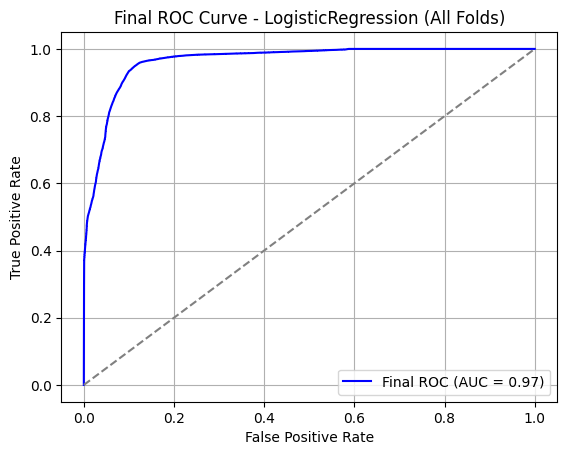

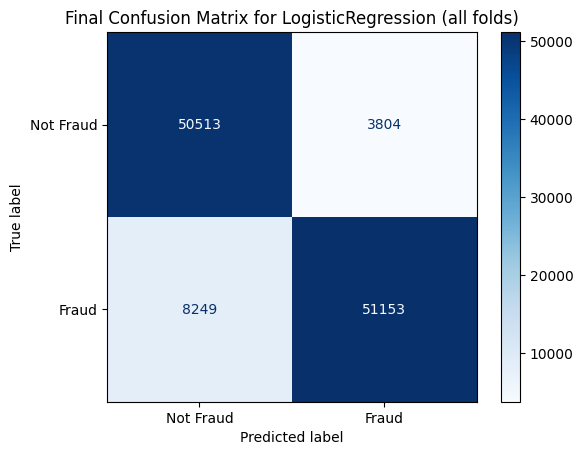



Final Classification Report
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     54317
           1       0.93      0.86      0.89     59402

    accuracy                           0.89    113719
   macro avg       0.90      0.90      0.89    113719
weighted avg       0.90      0.89      0.89    113719



In [16]:
# Running the model
model = LogisticRegression(max_iter=1000)
run_temporal_kfold(resampled_df, model)

# LGBM Classifier

In [17]:
# Oversampling experiment results can be found at:
# https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing

# Using ADASYN for LGBM Classifier
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
resampled_df = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)


Model: LGBMClassifier
[LightGBM] [Info] Number of positive: 41843, number of negative: 49135
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9690
[LightGBM] [Info] Number of data points in the train set: 90978, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459924 -> initscore=-0.160647
[LightGBM] [Info] Start training from score -0.160647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

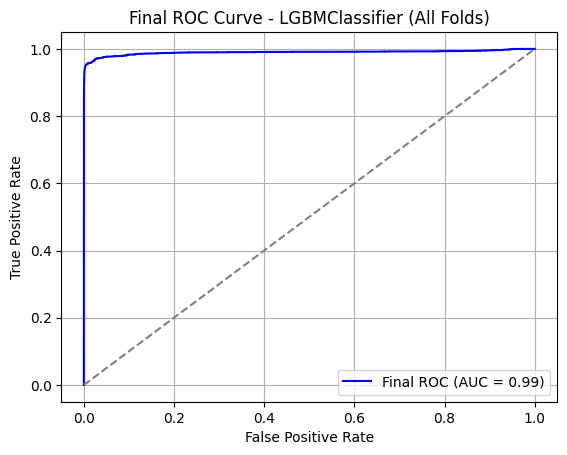

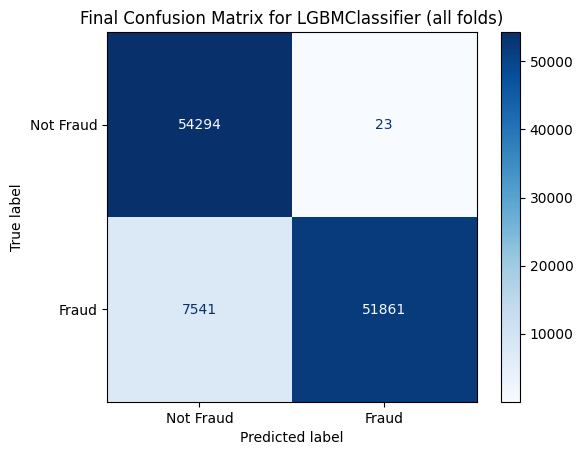



Final Classification Report
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     54317
           1       1.00      0.87      0.93     59402

    accuracy                           0.93    113719
   macro avg       0.94      0.94      0.93    113719
weighted avg       0.94      0.93      0.93    113719



In [18]:
# Running the model

model = lgb.LGBMClassifier(n_estimators=200, random_state=42)
run_temporal_kfold(resampled_df, model)

# Discussion and Conclusion

<h1> Discussion </h1>

<p>This experiment aimed to evaluate the performance of the <b>XGBClassifier, Logistic Regression and LGBM Classifier</b> on a temporally structured dataset for fraud detection. This is a matter of Binary Classification, where Fraud - 1, Non-Fraud - 0. </p>

<h3> Oversampling </h3>
<p> This dataset was significantly imbalanced, where the proportons were as follows: 0 - 99.827251
1 - 0.172749. This means that the selection of the oversampling technique was crucial. Experimentation was done with three oversampling techniques: </p>

<ul>
  <li> SMOTE </li>
  <li> ADASYN </li>
  <li> SVM </li>
</ul>

<p> Results of the techniques across each algorithm can be found at <a href="https://docs.google.com/document/d/1VCSaRQPcvjGzVNETezPAWO7yu2Gcmm_5nTvNxtn4vl0/edit?usp=sharing"> Oversampling Techniques Comparison </a></p>

<h3> Train/Test split </h3>
<p>Selecting the manner in which the data was split into training and testing sets was key, as it had a great impact on the model's ability to correctly classify Fraud and Non-Fraid cases. Three methods were investigated: </p>

<ul>
  <li> Temporal Split </li>
  <li> Statified K-Fold </li>
  <li> Temporal K-Fold </li>
</ul>

<p>The Temporal split intends to split all the data by occurance where 80% was for training and 20% for testing. This did produce the great results and so cross validation was investigated.</p>

<p>Statified K-Fold was then attempted, where data was split into 5 folds, and training/testing was done on each fold. This produced excellent results, particularly with XGBoost. The model, was so accurate with this method, that concerns of leakage was raised. These concerns stemmed from the fact that the Stratified K-Fold approach maintains the proportions of Positive to Negative Cases throughout each fold, but disregards temporal integrity. This prompted the investigation of a cross validation technique that implemented the temporal split, Temporal K-Fold</p>

<p> For the Temporal K-Fold to be done properly, the splitting into folds must be done in such a way that mimiced the Stratified approach, while disregarding the proportions of the data. After splitting into folds, the inital Temporal split was used to split data within each fold, maintaining temoral integrity and forcing the model to only learn from transactions.The results from this can be found at: <a href="https://docs.google.com/document/d/1VVB0Mg6i9mbF3k7Bl4IR0HgcMXI5GqtzqwLRY6Mf85A/edit?usp=sharing"> Temoral K-Fold Results</a></p>

<p> Logistic Regression benefited the most from Temporal K-Fold, as it became much less supseptable to the noise that can be introduced through oversampling methods. As a linear model, Logistic Regression is particularly sensitive to anomalies introduced by synthetic samples. Temporal K-Fold mitigates this by maintining the tempral structure and providing a more reaslistic distribution of data. Thus the selected oversampling technqiue across all algorithms was ADASYN, as it provided the best results. </p>


<h3> Lag Features </h3>
<p> Lag features promote learning from past transactions, as they provide a means for the model to utilize past values of variables that display a certain correlation with itself, essentially injecting memory into the model. To identify which variables benefited from lagging, both the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) were used, which identified these desired correlations by examining a variable's values at different lags.</p>

<p>Initially lag features had little to no effect across all algorithms, where the performance of some algorithms slightly deteriorated. However, once Temporal K-Fold was introduced,  the model's ability to utilize these lag features improved significantly. Through experimentation, the optimal amount of lag features for specific variables were determined and this served to improve the model's effectiveness across all algorithms.</p>

<h1>Conclusion</h1>
<p>This study explored fraud detection using <b>XGBoost, Logistic Regression, and LightGBM </b> on a highly imbalanced, time-ordered dataset. Results showed that <b>Temporal K-Fold</b> was essential for preserving temporal integrity, reducing data leakage, and producing more reliable evaluations</p>
<p><b>ADASYN</b> proved to be the most effective oversampling method across models, and <b>lag features</b> became beneficial when paired with Temporal K-Fold, helping models leverage past transaction behavior.</p>
<p>Among the models, <b>XGBoost</b> achieved the highest overall performance with an F1-score of 0.94, followed closely by <b>LightGBM</b> (0.93) and <b>Logistic Regression</b> (0.89). Notably, Logistic Regression saw the most improvement from Temporal K-Fold, becoming less subsceptible to oversampling noise.</p>
<p>Overall, the best performance was achieved by combining <b>Temporal K-Fold validation, ADASYN sampling, and optimized lag features</b>, with XGBoost consistently leading in predictive accuracy.</p>